In [5]:
import gpflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import warnings
import os
import operator
import sys
sys.path.insert(1, '../')

from hgpmoe.data import load_feature
from hgpmoe.metrics import compute_metrics_gpr, compute_metrics_hgpmoe
from hgpmoe.hgp import HierarchicalGP
from hgpmoe.moe import ExpertsMixGP
from hgpmoe.plot import pred_x

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

# Example of fitting GPR, HGP and MOE on simulated patient trajectories

- The simulated data is generated using 4 group level kernels and $N$ patient level kernels.
- Each patient has one of the following combination of group memberships:
    - [0, 2], [0, 3], [1, 2], and [1, 3] which map to cluster numbers 0, 1, 2 and 3, respectifully
- The **goal** of this notebook is to provide a concrete example that one can run without access to proprietary data. Furthermore, it shows that for certain structures of data, particularly those with naturally occurring **group structure** (i.e. EHR data), the HGP/MOE is a more effective model than GPR

# Load Simulated Data

In [32]:
import pickle

Y_full = list(np.load('../simulated_data/simulated_Y.npy', allow_pickle=True))
X_full = list(np.load('../simulated_data/simulated_X.npy', allow_pickle=True))
cluster_assignments_list = list(np.load('../simulated_data/simulated_cluster_assignments_list.npy', allow_pickle=True))
with open('../simulated_data/simulated_cluster_assignments_dict.pkl', 'rb') as f:
    cluster_assignments_dict = pickle.load(f)
feature = 'simulated'

X = []
Y = []
X_test = []
Y_test = []

# Split into train and test
for i in range(len(Y_full)):
    # train_idx = np.arange(0, int(len(Y0[i]) * 0.75))
    train_idx = np.random.choice(len(Y_full[i]), int(len(Y_full[i]) * 0.75), replace=False)
    train_idx = sorted(train_idx)
    X.append(X_full[i][train_idx])
    Y.append(Y_full[i][train_idx])
    mask = np.ones(Y_full[i].size, dtype=bool)
    mask[train_idx] = False
    X_test.append(X_full[i][mask])
    Y_test.append(Y_full[i][mask])

Y_arr = np.concatenate(Y)
Y_mean = Y_arr.mean()
Y_std = Y_arr.std()

noise_dict = dict()
for j in range(len(Y)):
    Y[j] = (Y[j] - Y_mean) / Y_std
    
for j in range(len(Y_test)):
    Y_test[j] = (Y_test[j] - Y_mean) / Y_std
print("Y", Y_mean, Y_std)

Y -0.004269539978873453 1.8072634375829706


### Take a look at the trajectories

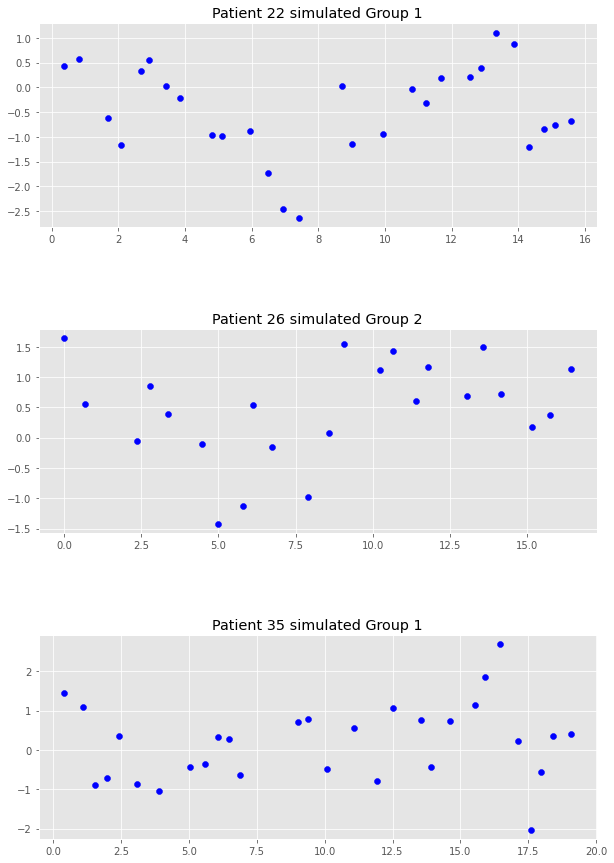

In [13]:
import matplotlib.pyplot as plt

n_examples = 3
fig, axs = plt.subplots(n_examples, 1, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

indices = np.random.choice(len(cluster_assignments_list), n_examples, replace=False)
indices = sorted(indices)
axs_idx = 0
for i in indices:
    axs[axs_idx].set_title('Patient %d ' %i + feature + " Group %d" %cluster_assignments_list[i])
    axs[axs_idx].scatter(X[i], Y[i], color='blue')
    axs_idx += 1
    

# Models

## GPR

Fit one GPR Model to each patient

In [38]:
gpr_models = []

for i in range(len(X)):
    k = gpflow.kernels.Matern52()
    m = gpflow.models.GPR(data=(X[i].reshape(-1, 1), Y[i].reshape(-1, 1)), kernel=k, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=1000))
    gpr_models.append(m)

In [39]:
# Check out parameters for one such model
print_summary(gpr_models[0])

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.915329
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.391211
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.27376e-06


In [40]:
# Compute metrics
gpr_train_mse, gpr_test_mse, gpr_train_r2, gpr_test_r2, gpr_ci = compute_metrics_gpr(gpr_models,
                                                                            X, Y, X_test, Y_test)

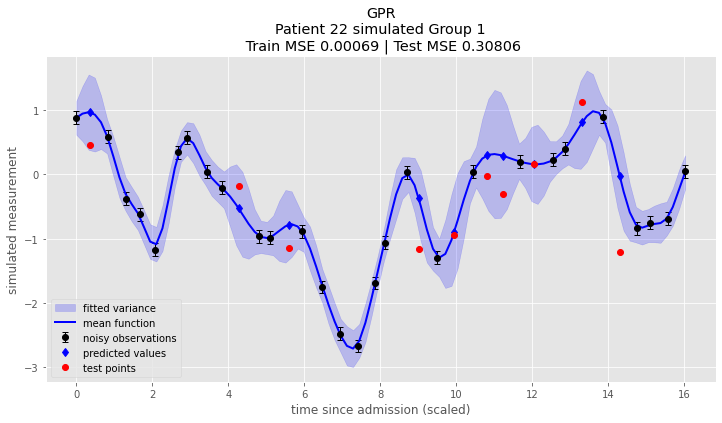

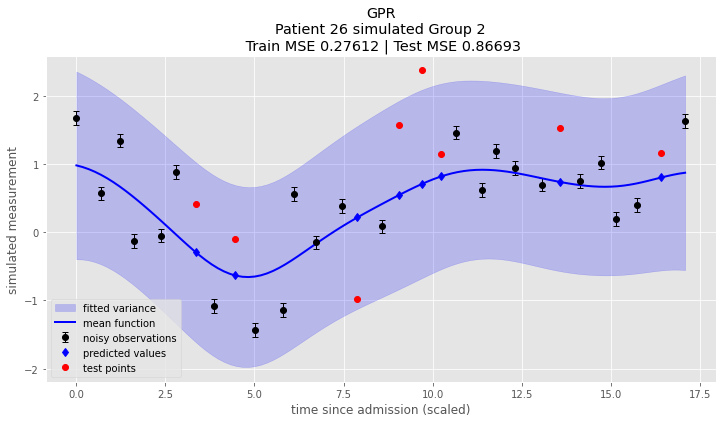

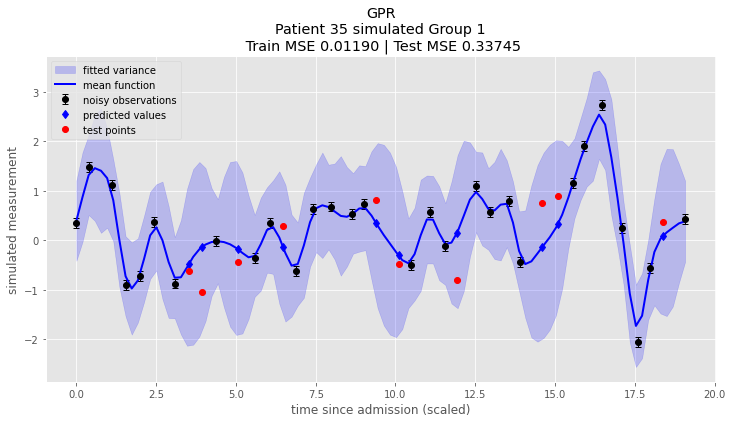

In [41]:
# Plot examples
for patient_idx in indices:
    pred_x(gpr_models[patient_idx], patient_idx, 
           X, Y,
           cluster_assignments_list,
           X_test=X_test, Y_test=Y_test, model_name='GPR',
           feature=feature, n_test_points=10)

# HGP

In [18]:
hgp = HierarchicalGP((X, Y), cluster_assignments_list, taper=True)
print_summary(hgp)

Patient  4  minimizes cluster  0
Patient  22  minimizes cluster  1
Patient  2  minimizes cluster  2
Patient  25  minimizes cluster  3


name,class,transform,prior,trainable,shape,dtype,value
HierarchicalGP.Wasserstein.variance,Parameter,Softplus,,False,(),float64,1
HierarchicalGP.Wasserstein.lengthscales,Parameter,Softplus,,False,(),float64,1
HierarchicalGP.K_group_list[0].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[0].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[1].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[1].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[2].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[2].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[3].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[3].lengthscales,Parameter,Softplus,,True,(),float64,1


In [19]:
opt = gpflow.optimizers.Scipy()
opt.minimize(hgp.training_loss, hgp.trainable_variables, options=dict(maxiter=1000))

Instructions for updating:
Do not call `graph_parents`.


      fun: 1172.4544707205027
 hess_inv: <89x89 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.28198341e-01,  7.90845226e-02, -2.31751752e-02, -1.57185105e-01,
        5.16372080e-03,  8.87384783e-02, -2.58698646e-02,  2.12434021e-03,
       -1.36114094e-02, -6.57897751e-02, -2.80504086e-03, -1.56263334e-02,
        5.55146305e-03, -6.05557379e-02,  5.37803372e-03, -5.37589350e-02,
       -2.11950595e-02,  2.16520305e-02,  1.81850097e-02, -1.83186026e-02,
        5.60984916e-02,  3.29400642e-03, -1.00369035e-02, -2.05850484e-02,
        2.91602708e-02, -1.83455857e-02,  1.32737735e-02, -2.56761125e-03,
        1.15734209e-01,  1.92441608e-02, -5.92259793e-02,  3.10595555e-03,
       -6.81873111e-02, -1.54373500e-02,  2.88889252e-02,  7.71526105e-03,
        3.35452393e-02, -1.76954418e-02,  1.19802788e-02,  2.13384517e-02,
        2.02027634e-04,  3.15764442e-02, -1.51098661e-02, -2.47912494e-02,
       -4.23867239e-02, -2.77072134e-02, -1.84827779e-03, -5.51759113e-03,
 

In [20]:
hgp_train_mse, hgp_test_mse, hgp_train_r2, hgp_test_r2, hgp_ci = compute_metrics_hgpmoe(hgp,
                                                                            X, Y, X_test, Y_test)

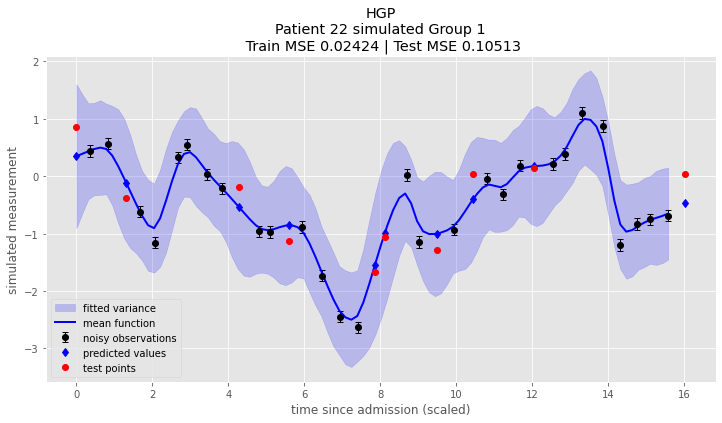

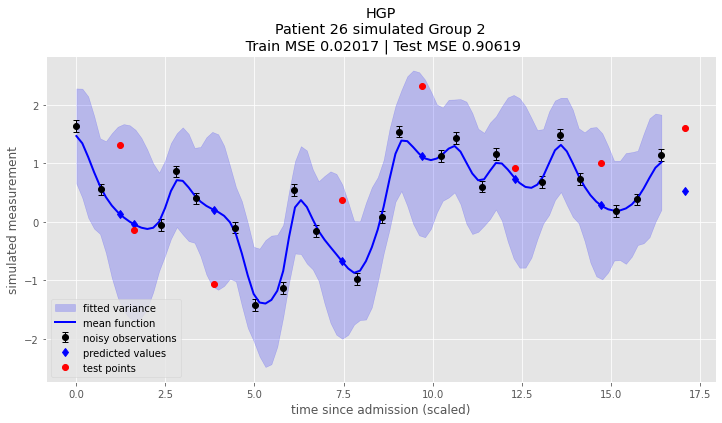

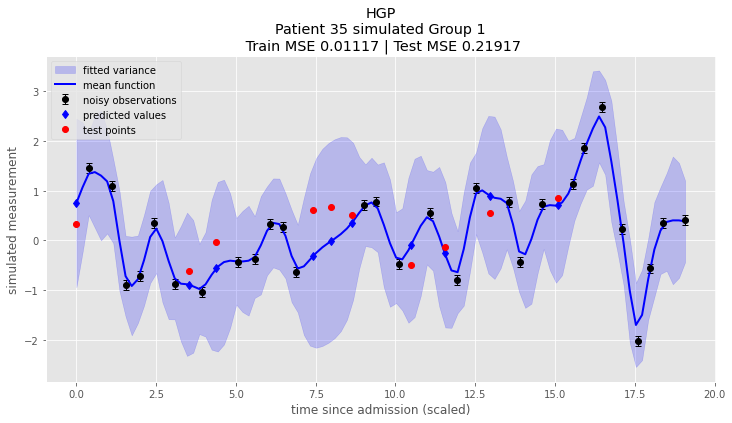

In [22]:
# Plot examples
for patient_idx in indices:
    pred_x(hgp, patient_idx, 
           X, Y,
           cluster_assignments_list,
           X_test=X_test, Y_test=Y_test, model_name='HGP',
           feature=feature, n_test_points=10)

# MOE

In [48]:
moe = ExpertsMixGP((X, Y), cluster_assignments_dict, taper=True)
print_summary(moe)

Patient  4  minimizes cluster with attribute 0
Patient  32  minimizes cluster with attribute 1
Patient  32  minimizes cluster with attribute 2
Patient  10  minimizes cluster with attribute 3


name,class,transform,prior,trainable,shape,dtype,value
ExpertsMixGP.Wasserstein.variance,Parameter,Softplus,,False,(),float64,1
ExpertsMixGP.Wasserstein.lengthscales,Parameter,Softplus,,False,(),float64,1
ExpertsMixGP.K_group['0'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['0'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['1'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['1'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['2'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['2'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['3'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['3'].lengthscales,Parameter,Softplus,,True,(),float64,1


In [44]:
# def optimization_step(model):
#     with tf.GradientTape(watch_accessed_variables=False) as tape:
#         tape.watch(model.trainable_variables)
#         loss = model.training_loss()
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables))
#     return loss

tf_optimization_step = tf.function(optimization_step)

optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(moe.training_loss, moe.trainable_variables, options=dict(maxiter=1000))

      fun: 1199.2965378887884
 hess_inv: <89x89 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.59109555e-04,  1.11097033e-02,  1.18891262e-05,  7.86505810e-04,
        2.62642619e-05,  1.20253082e-03,  1.83095649e-05,  9.69506657e-04,
        5.77859959e-03, -3.33693630e-03,  1.30523318e-03,  2.07258334e-03,
       -2.95380963e-04, -3.28530116e-03,  4.18860819e-05, -4.98305149e-03,
       -3.95783487e-03, -2.88753030e-03,  1.77891216e-03,  3.37853579e-04,
        5.23431494e-03, -8.32364776e-04, -5.74819677e-04,  2.15361513e-03,
        1.14129516e-03, -3.85501457e-03,  3.84479168e-03, -2.61264892e-05,
       -2.38234168e-02, -4.19520286e-02, -6.14849811e-03,  4.90090201e-03,
        2.53614804e-03, -2.70196448e-03, -4.94188285e-03, -1.01623608e-02,
        1.54168229e-02, -6.93378482e-03,  7.00877581e-03, -4.05840236e-03,
       -2.81158762e-04,  2.45655546e-05,  1.60634313e-02, -6.51337442e-03,
        3.07110294e-03, -6.28452931e-03, -1.15832778e-02, -9.89825107e-03,
 

In [45]:
moe_train_mse, moe_test_mse, moe_train_r2, moe_test_r2, moe_ci = compute_metrics_hgpmoe(moe,
                                                                            X, Y, X_test, Y_test)

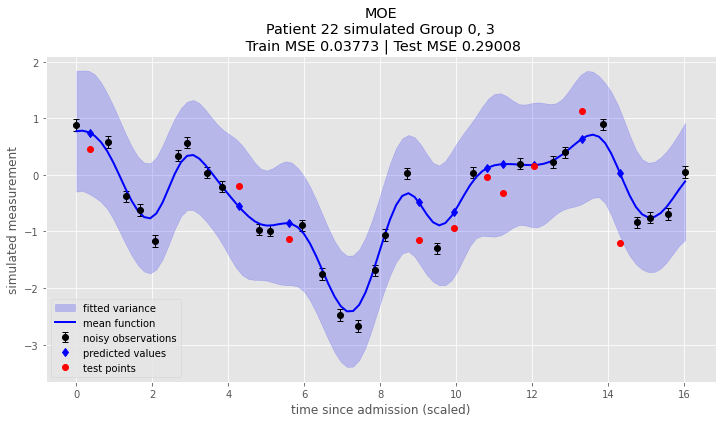

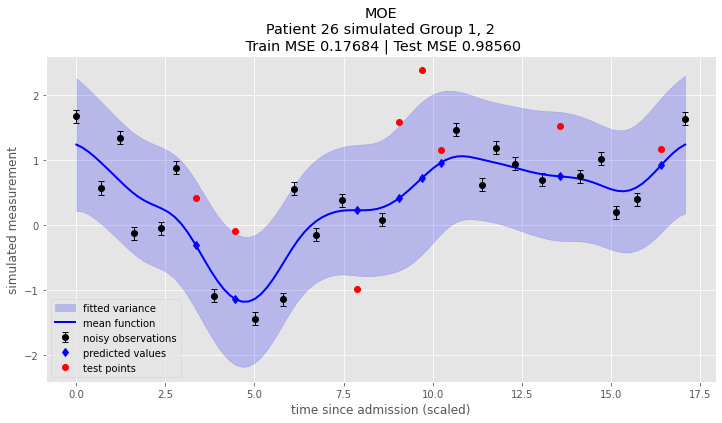

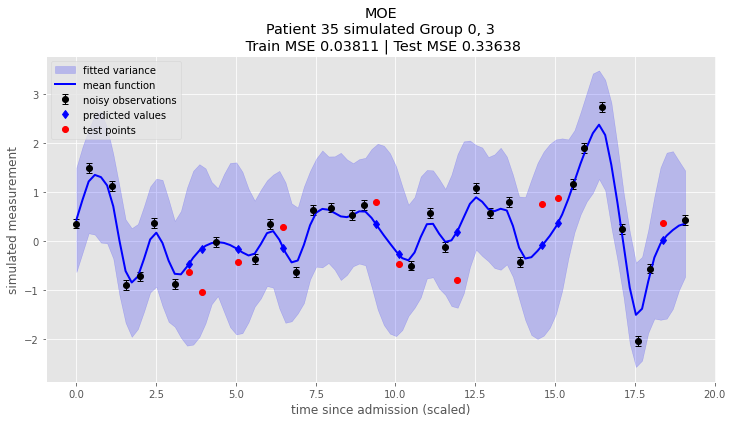

In [46]:
# Plot examples
for patient_idx in indices:
    pred_x(moe, patient_idx, 
           X, Y,
           cluster_assignments_dict,
           X_test=X_test, Y_test=Y_test, model_name='MOE',
           feature=feature, n_test_points=10)

### Compare Metrics

In [47]:
r2_count_moe, = np.where(moe_train_r2 > gpr_train_r2)

print("Train R^2 is higher for MOE than GPR for %.3f%% of patients" %(len(r2_count_moe)/len(moe_ci) * 100))
print(" ")

r2_count_moe, = np.where(moe_test_r2 > gpr_test_r2)

print("Test R^2 is higher for MOE than GPR for %.3f%% of patients" %(len(r2_count_moe)/len(moe_ci) * 100))
print("")

ci_count_moe, = np.where(np.abs(moe_ci - 5) < np.abs(gpr_ci - 5))      
ci_same_moe, = np.where(np.abs(moe_ci - 5) == np.abs(gpr_ci - 5))

print("95%% CI is better for MOE than GPR for %.3f%% of patients" %(len(ci_count_moe)/len(moe_ci) * 100),
     " and the same for %.3f%% of patients" %(len(ci_same_moe)/len(moe_ci) * 100))

Train R^2 is higher for MOE than GPR for 50.000% of patients
 
Test R^2 is higher for MOE than GPR for 52.500% of patients

95% CI is better for MOE than GPR for 10.000% of patients  and the same for 87.500% of patients
